## Creates binarized Seurat objects, and merges them and finds Top Features (min.cutoff=20)

In [1]:
# Input info
exp <- "Flt3l"
singlecell_sumstats_dir <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/"

#prefix <- "CHIP_april08_2021_Croker/MTblacklist/"
#cellr_indir <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist"
#frag_file <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/fragments.tsv.gz"

# External
external_dat_dir <- "/data2/mito_lineage/Analysis/annotation/output/data/granja_cd34"
external_frag_file <- "granja_cd34.fragments.tsv"
external_prefix <- "GSE129785_scATAC-Hematopoiesis-CD34"
external_dat_file <- "granja_10X_CD34.rds"

# Saving
outdir <- "/data2/mito_lineage/Analysis/annotation/output/data/"

# Parameters
nTop = 25000

In [2]:
external_frag_full <- file.path(external_dat_dir, external_frag_file)
ext_frag_file <- gsub('.fragments.tsv', '.fragments.sort.tsv.gz', external_frag_full)

external_frag_full

[1] "/data2/mito_lineage/Analysis/annotation/output/data/granja_cd34/granja_cd34.fragments.tsv"

In [3]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)

library(future)
plan()
#plan("multiprocess", workers = workers)
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The follow

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

## Merge peaks

In [4]:
# read in peak sets
peaks.ext <- read.table(
  file = file.path(external_dat_dir, paste0(external_prefix, ".peaks.bed")),
  col.names = c("chr", "start", "end")
)


peaks.curr <- read.table(
  file = file.path(singlecell_sumstats_dir, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"),
  col.names = c("chr", "start", "end")
)


# convert to genomic ranges
gr.ext <- makeGRangesFromDataFrame(peaks.ext)
gr.curr <- makeGRangesFromDataFrame(peaks.curr)


# Create a unified set of peaks to quantify in each dataset
#combined.peaks <- reduce(x = c(gr.500, gr.1k, gr.5k, gr.10k))
combined.peaks <- reduce(x = c(gr.ext, gr.curr))

# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]
combined.peaks

GRanges object with 673737 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1        9872-10738      *
       [2]     chr1       96454-96767      *
       [3]     chr1     115476-115976      *
       [4]     chr1     180692-181142      *
       [5]     chr1     191619-191976      *
       ...      ...               ...    ...
  [673733]     chrY 56827593-56827757      *
  [673734]     chrY 56855786-56855993      *
  [673735]     chrY 56858852-56858882      *
  [673736]     chrY 56870805-56871155      *
  [673737]     chrY 56872236-56872286      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Create fragment objects

In [28]:
barcode_path <- file.path(singlecell_sumstats_dir, exp, "outs", "filtered_peak_bc_matrix", "barcodes.tsv")
barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)

frag_file <- file.path(singlecell_sumstats_dir, exp, "outs", "fragments.tsv.gz")

# quantify multiome peaks in the scATAC-seq dataset
frags.curr <- CreateFragmentObject(path = frag_file,
                                  cells= barcodes[["X1"]])

barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=exp)


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character()
)


Computing hash



In [6]:
barcode_path <- file.path(external_dat_dir, paste0(external_prefix, ".cell_barcodes.txt"))


metadata <- read.csv(
  file = file.path(external_dat_dir, paste0(external_prefix, ".cell_barcodes.txt")),
  header = TRUE,
  sep='\t',
)
#CD34boo <- colData$Group %in% c("CD34_Progenitors_Rep1","CD34_Progenitors_Rep2")
c1boo <-  metadata$Group %in% c("BM_pDC", "CLP", "CMP", "GMP", "HSC", "LMPP", "MEP", "Monocytes", "MPP")
metadata <- metadata[c1boo,]

rownames(metadata) <- metadata$Group_Barcode
metadata$proj <- "granja_cd34"
ext_cell_names <- rownames(metadata)
metadata <- metadata[,c("Group", "proj")]
ext_cell_names

[1] "Monocytes#ATTTGTCCACAGAAGC-1"              
   [2] "Monocytes#ACTGCAATCTTCCAGC-1"              
   [3] "Monocytes#CCGAAGCGTCGTAGTT-1"              
   [4] "Monocytes#TGGAAGGCAAGGCGTA-1"              
   [5] "Monocytes#CGCACAGGTCACCCGA-1"              
   [6] "Monocytes#TTGCACCGTGAATCAA-1"              
   [7] "Monocytes#AATGGCTGTACATGGG-1"              
   [8] "Monocytes#ACTATTCGTCTCGGGT-1"              
   [9] "Monocytes#AGTGCGCTCGTCGCAG-1"              
  [10] "Monocytes#ACAGCGCTCACTCGGG-1"              
  [11] "Monocytes#CTCTCGAAGAAATGGG-1"              
  [12] "Monocytes#ACCATCCGTCGCTAGC-1"              
  [13] "Monocytes#AACCTTTCAACAAACA-1"              
  [14] "Monocytes#CTAGCGGTCGTGCTTC-1"              
  [15] "Monocytes#TTATGTCTCATTGCCC-1"              
  [16] "Monocytes#GTGCCAGGTTCCTATT-1"              
  [17] "Monocytes#GGATAGGAGATGAGGA-1"              
  [18] "Monocytes#AGCCTGGAGAACGCCA-1"              
  [19] "Monocytes#AACAAAGTCTTACTCA-1"              
  [20] "Monocytes#GGCGAAAGTGCGCATC-1"              
  [21] "Monocytes#CAGCTAACACGCGCAT-1"              
  [22] "Monocytes#CTTGAAGAGAGTTCGG-1"              
  [23] "Monocytes#GCGAGTCCACAAACAA-1"              
  [24] "Monocytes#GCATGATAGCTACGTT-1"              
  [25] "Monocytes#CACTAAGAGGCCAATG-1"              
  [26] "Monocytes#AATACGCAGCGTAGCA-1"              
  [27] "Monocytes#ACTGCGGAGGCAATTA-1"              
  [28] "Monocytes#GTTATTCTCGGTCTAA-1"              
  [29] "Monocytes#GCCCAGAAGTGTTCCA-1"              
  [30] "Monocytes#CCTTGCAGTATTCTTC-1"              
  [31] "Monocytes#GGAGAACAGAGCAGCT-1"              
  [32] "Monocytes#TTAGCGAGTGACGCAA-1"              
  [33] "Monocytes#TCAGGGCAGCATGATA-1"              
  [34] "Monocytes#TACATTCCAGATACAA-1"              
  [35] "Monocytes#GTGACATCATCGTACA-1"              
  [36] "Monocytes#GCTGTTCGTACGTATC-1"              
  [37] "Monocytes#TGACAACAGTCTGGGA-1"              
  [38] "Monocytes#GCTCAGGTCTAGCTGA-1"              
  [39] "Monocytes#GGCGTTGTCCCACTAC-1"              
  [40] "Monocytes#AGCCGCAAGGCAGTAC-1"              
  [41] "Monocytes#GAACTTGGTCTGAGCC-1"              
  [42] "Monocytes#GTAGTACCAATACTGC-1"              
  [43] "Monocytes#ATTACTCTCGCGCCAA-1"              
  [44] "Monocytes#AACAGTCCATCGTACA-1"              
  [45] "Monocytes#AGCCTTCTCCTTACGC-1"              
  [46] "Monocytes#TGCTATTGTTCCATCC-1"              
  [47] "Monocytes#AGTCCGGCACTAAACC-1"              
  [48] "Monocytes#ATCCAGAAGGTTACAA-1"              
  [49] "Monocytes#GAGGTCCTCGTCTTAT-1"              
  [50] "Monocytes#TAGCCCTGTAGCGAGT-1"              
  [51] "Monocytes#AAGGAGCCAGTATCTG-1"              
  [52] "Monocytes#TTGCGAACACACTAGT-1"              
  [53] "Monocytes#CTTGTCGCAACGGACA-1"              
  [54] "Monocytes#ACTGCGGGTAATGCAA-1"              
  [55] "Monocytes#TAATCGGGTGATGTGG-1"              
  [56] "Monocytes#GCATTCCCACTGTTAG-1"              
  [57] "Monocytes#AACTTGGTCAACACGT-1"              
  [58] "Monocytes#CTGGGACAGGGTAATT-1"              
  [59] "Monocytes#TGTACGAAGGGAAATG-1"              
  [60] "Monocytes#CCCTGATTCCGTCAAA-1"              
  [61] "Monocytes#GATCATGCATAGGCGA-1"              
  [62] "Monocytes#GGGACCTGTCTAAGAA-1"              
  [63] "Monocytes#GATCATGTCCATAACG-1"              
  [64] "Monocytes#TATGTTCCACTTGCGG-1"              
  [65] "Monocytes#TGGACATCAAGGGAGG-1"              
  [66] "Monocytes#CCTGCTATCTAAGGTC-1"              
  [67] "Monocytes#GTGTGATGTAGAATAC-1"              
  [68] "Monocytes#TCAGTTTTCGACTCGG-1"              
  [69] "Monocytes#CTGGCAGTCGCAACTA-1"              
  [70] "Monocytes#TGGCAATGTTAGCTCA-1"              
  [71] "Monocytes#GACCCAGAGTGCTAGG-1"              
  [72] "Monocytes#GACCAATCAAGCGGTA-1"              
  [73] "Monocytes#CATAACGAGGGTAATT-1"              
  [74] "Monocytes#TACGGATTCTTGTGCC-1"              
  [75] "Monocytes#TAACGGTGTCCACCAG-1"              
  [76] "Monocytes#ATATTCCTCAGAATGA-1"              
  [77] "Monocytes#GCCCGAAGTTGCCGCA-1"              

In [7]:
# quantify multiome peaks in the scATAC-seq dataset
frags.ext <- CreateFragmentObject(path = ext_frag_file,
                                  cells= ext_cell_names)

Computing hash



## Quantify peaks

In [14]:
ext.counts <- FeatureMatrix(
  fragments = frags.ext,
  features = combined.peaks,
  cells = rownames(metadata)
)

Extracting reads overlapping genomic regions



In [30]:
curr.counts <- FeatureMatrix(
  fragments = frags.curr,
  features = combined.peaks,
  cells = rownames(barcodes)
)


Extracting reads overlapping genomic regions



## Create the objects 

In [15]:
ext_assay <- CreateChromatinAssay(ext.counts, fragments = frags.ext)
ext <- CreateSeuratObject(ext_assay, assay = "ATAC", project="granja_cd34", meta.data=metadata)


In [16]:
ext

An object of class Seurat 
673629 features across 2196 samples within 1 assay 
Active assay: ATAC (673629 features, 0 variable features)

In [31]:
curr_assay <- CreateChromatinAssay(curr.counts, fragments = frags.curr)
curr <- CreateSeuratObject(curr_assay, assay = "ATAC", project=exp, meta.data=barcodes)

In [32]:
curr.counts

   [[ suppressing 31 column names 'AAACGAAAGGAAACTT-1', 'AAACGAAGTCCAAGAG-1', 'AAACGAAGTCCGAGCT-1' ... ]]

   [[ suppressing 31 column names 'AAACGAAAGGAAACTT-1', 'AAACGAAGTCCAAGAG-1', 'AAACGAAGTCCGAGCT-1' ... ]]

   [[ suppressing 31 column names 'AAACGAAAGGAAACTT-1', 'AAACGAAGTCCAAGAG-1', 'AAACGAAGTCCGAGCT-1' ... ]]



673737 x 5313 sparse Matrix of class "dgCMatrix"
                                                                                         
chr1-9872-10738      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-96454-96767     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-115476-115976   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-180692-181142   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-191619-191976   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-236856-237356   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-237511-238011   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-240801-241301   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-250084-250584   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1-267770-268268   . . . . . . . . . . . . . . . 

In [36]:
curr

An object of class Seurat 
673737 features across 5313 samples within 1 assay 
Active assay: ATAC (673737 features, 0 variable features)

In [37]:
ext <- BinarizeCounts(ext)
curr <- BinarizeCounts(curr)


In [38]:
saveRDS(ext, file.path(outdir, external_dat_file))
saveRDS(curr, file.path(outdir, paste0(exp, ".rds")))

## Merge

In [39]:
# merge all datasets, adding a cell ID to make sure cell names are unique
combined <- merge(
  x = ext,
  y = curr,
  add.cell.ids = c("ext", exp)
)
combined[["ATAC"]]

ChromatinAssay data with 673737 features for 7509 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 2 

In [40]:
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined

An object of class Seurat 
673737 features across 7509 samples within 1 assay 
Active assay: ATAC (673737 features, 327383 variable features)

In [41]:
saveRDS(combined, file.path(outdir, paste0(exp, ".merged.rds")))

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
03:56:19 UMAP embedding parameters a = 0.9922 b = 1.112

03:56:19 Read 7509 rows and found 49 numeric columns

03:56:19 Using Annoy for neighbor search, n_neighbors = 30

03:56:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

03:56:21 Writing NN index file to temp file /tmp/RtmpiOClKb/

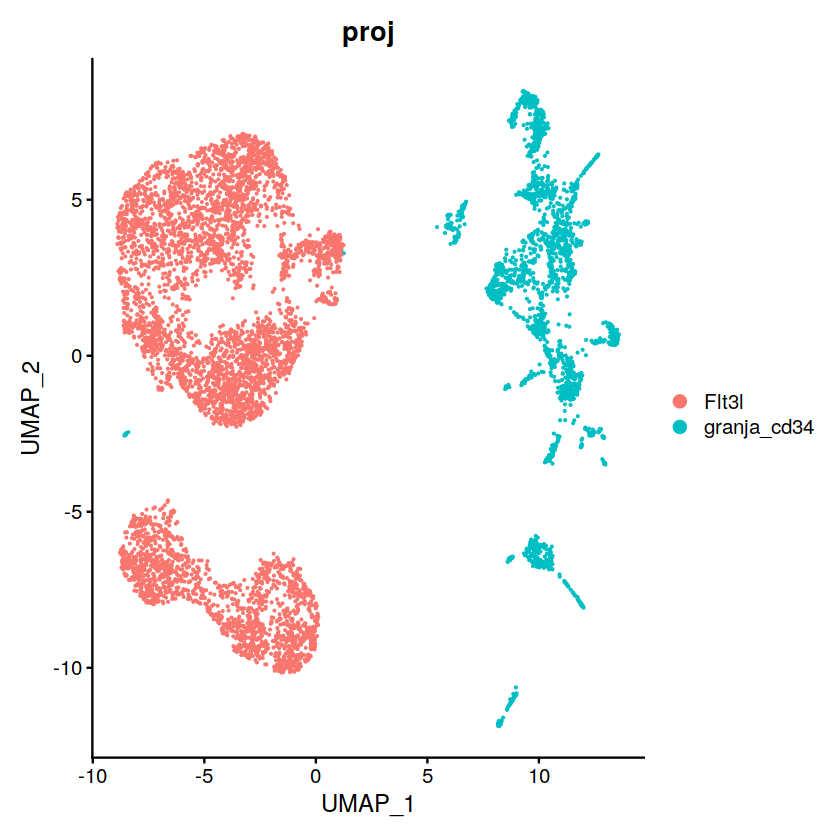

In [42]:
combined <- RunTFIDF(combined)
combined <- RunSVD(combined)
combined <- RunUMAP(combined, dims = 2:50, reduction = 'lsi')
DimPlot(combined, group.by = "proj", pt.size = 0.1)

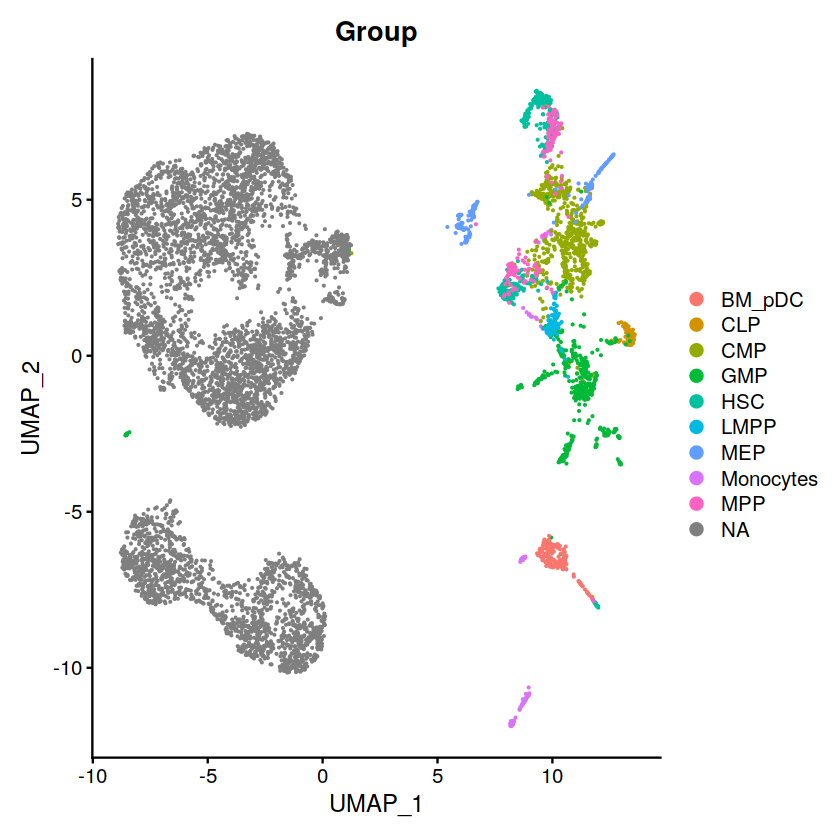

In [43]:
DimPlot(combined, group.by = "Group", pt.size = 0.1)

In [18]:
create_se <- function(countsA, countsB, frags.countsA, frags.countsB){
    countsA_assay <- CreateChromatinAssay(countsA, fragments = frags.countsA)
    countsA <- CreateSeuratObject(countsA_assay, assay = "ATAC")
    
    countsB_assay <- CreateChromatinAssay(countsB, fragments = frags.countsB)
    countsB <- CreateSeuratObject(countsB_assay, assay = "ATAC")
    countsB$dataset <- 'granja_cd34'
    countsA$dataset <- exp
    
    # merge all datasets, adding a cell ID to make sure cell names are unique
    combined <- merge(
      x = countsB,
      y = countsA,
      add.cell.ids = c("countsB", exp)
    )
    combined[["ATAC"]]
    combined <- RunTFIDF(combined)
    combined <- FindTopFeatures(combined, min.cutoff = 20)
    combined <- RunSVD(combined)
    combined <- RunUMAP(combined, dims = 2:50, reduction = 'lsi')
    DimPlot(combined, group.by = 'dataset', pt.size = 0.1)
    return(combined)
}

### Make sure the peaks overlap

In [19]:
onlyOverlap <- FALSE
if (onlyOverlap){
    peaks_in_curr <- names(which(rowSums(curr.counts)>0))
    peaks_in_ext <- names(which(rowSums(ext.counts)>0))
    peaks_both <- intersect(peaks_in_curr, peaks_in_ext)
    overlap.curr.counts <- curr.counts[peaks_both,]
    overlap.ext.counts <- ext.counts[peaks_both,]

    combined <- create_se(overlap.curr.counts, overlap.ext.counts, frags.curr, frags.ext)
    DimPlot(combined, group.by = 'dataset', pt.size = 0.1)
    saveRDS(combined, file.path(outdir, paste0(exp, ".merged.over0Peaks.rds")))
}